In [22]:
import pandas as pd
import numpy as np
import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Functions to prepare the datasets

In [23]:
def fixed_budget_and_dataset_for_variant(voc,RETURN_DT = False):
    #define the total number of sequences avaiable (our fixed budget) based on Brazil data
    country = 'br'
    
    if voc == 'alpha' or voc == 'beta':
        DESIG = 352
    elif voc == 'gamma':
        DESIG = 376
    elif voc == 'delta':
        DESIG = 459 #VOC:496, VOI:459
        
    THIS_START = DESIG - int(MAX_DAY/2)
    
    df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
    df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
    df.index = df['date']
    df = df.drop(df.loc[:THIS_START].index)

    new_df = []

    for index, row in df.iterrows(): #iterating over time bins
        K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
        N = len(row['variant']) #total number of sequences in time bin

        new_df.append((row['date'],N,K))

    new_df = pd.DataFrame(new_df, columns = ['delay', 'N', 'K'])
    
    total_budget = 0
    for N_sequences in new_df['N'][int(MAX_DAY/2):]: #iterate over dates
        total_budget += N_sequences
    
    if RETURN_DT:
        return total_budget, new_df
    else:
        return total_budget


def start_from_random_back_forward_between_designation(voc,country,MAX_DAY,df_cases_bool = False):
    
    #Cut Data Frame to start in day of designation - MAX_DAY/2, MAX_DAY is usually 31
    #so the df starts 15 days before designation
    
    if voc == 'alpha' or voc == 'beta':
        DESIG = 352
    elif voc == 'gamma':
        DESIG = 376
    elif voc == 'delta':
        DESIG = 459 #VOC:496, VOI:459
    
    THIS_START = DESIG - int(MAX_DAY/2)
    
    #if this function will return just the new_df (it is not the Case strategy)
    if df_cases_bool == False:  
        df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
        df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
        df.index = df['date']
        df = df.drop(df.loc[:THIS_START].index)

        new_df = []
        for index, row in df.iterrows(): #iterating over time bins
            K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
            N = len(row['variant']) #total number of sequences in time bin

            new_df.append((row['date'],N,K))

        new_df = pd.DataFrame(new_df, columns = ['delay', 'N', 'K'])
        return new_df
    
    #if this function will return both the new_df and the cases df (it is the Case strategy)
    else: 
        
        if country == 'en':
            country_cases = 'england'
        elif country == 'usa':
            country_cases = 'usa'

        #Simplified data frame of cases in the country
        df_cases = pd.read_table("/home/renata/Desktop/gabriela_group/final/data_{0}_covid19_number_cases.csv".format(country_cases),sep=',') #data
        df_cases = df_cases[['date','newCases']]
        d = datetime.datetime(2020, 1, 1) 
        df_cases['date'] = pd.to_datetime(df_cases['date'])
        df_cases['date'] = (df_cases['date']-d).dt.days
    
        #Data frame to sequencing in the country
        df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
        df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
        df.index = df['date']
        df = df.drop(df.loc[:THIS_START].index)
        df.index = range(len(df))
        
        #Makes df_br have the same days of the df = Now they have the same days
        for date_cases in df_cases['date']:
            try:
                df.loc[df['date'] == date_cases].index[0]
            except:
                ind = df_cases.loc[df_cases['date'] == date_cases].index[0]
                df_cases = df_cases.drop([ind])
        df_cases.index = range(len(df_cases))
        
        new_df = []
        new_df_cases = []
        
        for index, row in df.iterrows(): #iterating over time bins
            K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
            N = len(row['variant']) #total number of sequences in time bin
            N_cases = df_cases['newCases'][index] #number of new cases in this index
            
            new_df.append((row['date'],N,K))
            new_df_cases.append((row['date'],N_cases))
            
        new_df = pd.DataFrame(new_df, columns = ['delay', 'N', 'K'])
        new_df_cases = pd.DataFrame(new_df_cases,columns = ['delay', 'Ncases'])
        
        return new_df,new_df_cases
    

## Subsampling strategies

In [24]:
#Function that implements each strategy

def subsamplesimulation(country,voc,Nit, MAX_DAY, strategy):
    # given a dataframe df, the rate of subsampling p and number of subsampling iterations Nit
    # return mean and standard deviation of delay of first detection
    
    delays = [] #list of observed delays for each sampling round
    #daily_budget_list = []
    
    APPEARANCE = detection_appearance(country,voc)

    if strategy == 'BRproportion':
        df_country = start_from_random_back_forward_between_designation(voc,country,MAX_DAY)
        br_budget, br_df = fixed_budget_and_dataset_for_variant(voc,RETURN_DT = True)
        
        for i in range(Nit):
        #For each iteration of Monte Carlo, it selects a random number between [0,MAX_DAY] to start the strategy
            start_day_idx = np.random.randint(0, MAX_DAY)
            
            if MAX_DAY == 1:
                start_day = APPEARANCE
            else:
                start_day =  df_country['delay'][start_day_idx]

            df_country_iter = df_country.iloc[start_day_idx :]
            br_df_iter = br_df.iloc[start_day_idx:]
            
            for index, row in df_country_iter.iterrows(): #iterate over dates
                daily_budget = br_df_iter['N'][index] #get the Nsamples of Brazil in this index(day)
                if subsampletest(row, daily_budget): #test to see if any voc is caught in the subsampling of that date
                    delays.append(row['delay']-start_day)
                    #daily_budget_list.append(int(daily_budget))
                    break
        
        return delays
    
    elif strategy == 'casesproportion':
    #Cases proportion
    #The daily budget is the total br budget*proportion of cases in this day relative to the total amount of cases
    #in the time series of this variant (the time series contains just the days since detection of the variant)
        df_country, df_country_cases = start_from_random_back_forward_between_designation(voc,country,MAX_DAY,True)
        br_budget = fixed_budget_and_dataset_for_variant(voc)
        
        for i in range(Nit):
            #For each iteration of Monte Carlo, it selects a random number between [0,MAX_DAY] to start the strategy
            start_day_idx = np.random.randint(0, MAX_DAY)
            df_country_iter = df_country.iloc[start_day_idx:]
            df_country_cases_iter = df_country_cases.iloc[start_day_idx:]
            if MAX_DAY == 1:
                start_day = APPEARANCE
            else:
                start_day =  df_country['delay'][start_day_idx]

            
            for index, row in df_country_iter.iterrows(): #iterate over dates
                dayproportion = float(df_country_cases_iter['Ncases'][index])/float(sum(df_country_cases['Ncases'])) #propotion of cases in relation to the total amount of cases
                daily_budget = float(br_budget)*float(dayproportion) #get the Nsamples of Brazil in this day based on the proportion relative to the total number of cases                
                if subsampletest(row, daily_budget): #test to see if any voc is caught in the subsampling of that date
                    delays.append(row['delay']-start_day)
                    #daily_budget_list.append(int(daily_budget))
                    break
    
        return delays  

    elif strategy == 'fixedDays':
        #plot the daily budget for each fixed amount of days
        df_country = start_from_random_back_forward_between_designation(voc,country,MAX_DAY)
        br_budget = fixed_budget_and_dataset_for_variant(voc)
        days_dict = {}
        
        for fixed_days in [7,14,30,60,90,120]:
            delays = []
            not_found = []
            budget_list = []
            
            daily_budget = br_budget/fixed_days
            budget_list.append(daily_budget)

            for i in range(Nit):
            #For each iteration of Monte Carlo, it selects a random number between [0,MAX_DAY] to start the strategy
                start_day_idx = np.random.randint(0, MAX_DAY)
                
                #Different measures of delay
                if MAX_DAY == 1:
                    start_day = APPEARANCE
                else:
                    start_day = df_country['delay'][start_day_idx]
                    
                df_country_iter = df_country.iloc[start_day_idx:] #start from the day in the window [MAX_DAY]
                
                for index, row in df_country_iter.iterrows(): #iterate over dates
                    try:
                        END_DAY = df_country['delay'][start_day_idx+fixed_days]
                    except:
                        END_DAY = df_country['delay'][len(df_country['delay'])-1] #last day of time series
                        
                    if row['delay'] <= END_DAY:
                        #the daily budget can be used just in the period defined as quantil_value of the time series
                        
                        if subsampletest(row, daily_budget): #test to see if any voc is caught in the subsampling of that date
                            delays.append(row['delay']-start_day)
                            break
                    else:
                        not_found.append(start_day)
            
            days_dict[fixed_days] = [delays,budget_list,not_found]
    
        return days_dict
    
    elif strategy == 'homogeneousBR':
        
        USA_ratio = 589820/33498545
        ENG_ratio = 347970/4605805
        BR_ratio = 20788/17628588

        if country == 'en':
            COUNTRY_ratio = ENG_ratio
        elif country == 'usa':
            COUNTRY_ratio = USA_ratio
            
        df_country = start_from_random_back_forward_between_designation(voc,country,MAX_DAY)
        br_budget = fixed_budget_and_dataset_for_variant(voc)
        
        for i in range(Nit):
            #For each iteration of Monte Carlo, it selects a random number between [0,MAX_DAY] to start the strategy
            start_day_idx = np.random.randint(0, MAX_DAY)
            df_country_iter = df_country.iloc[start_day_idx:]
            if MAX_DAY == 1:
                start_day = APPEARANCE
            else:
                start_day =  df_country['delay'][start_day_idx]

            
            for index, row in df_country_iter.iterrows(): #iterate over dates
                N_original = float(df_country_iter['N'][index]) #original sampling of this date
                p = BR_ratio/COUNTRY_ratio
                daily_budget = int(N_original*p) #homogeneous proportion of this day
                
                if subsampletest(row, daily_budget): #test to see if any voc is caught in the subsampling of that date
                    delays.append(row['delay']-start_day)
                    #daily_budget_list.append(int(daily_budget))
                    break
                    
        return delays
        

    
#Given the nsample and the date, try to find the voc
def subsampletest(dfrow, nsample,delay=None):
    # given a row from a dataframe = (delay, N, K) and the budget for that day (day_budget)
    # randomly samples a Hypergeometric(N, K, day_budget) and returns
    # True if the sample contains one of the K marked items
    # False otherwise
    N = dfrow['N'] # total sequence count
    K = dfrow['K'] # voc sequence count
    # now we need to define the number of samples to be taken
    Nsample = int(nsample)
    if Nsample:
        # np.random.hypergeometric(N - K, K, Nsample) returns the number of non-voc samples
        # obtaining in a sampling of the distribution above. Thus, the voc is detect
        # if and only if that number is less than Nsample = found voc samples
        try: 
            return np.random.hypergeometric(N - K, K, Nsample) < Nsample
        except:
            if K > 0:
                return True#in the case we have more sampling budget then the "total cases" we will find the variant
            else:
                return False
    return False


#Detect the first day of appearance of a VOC
def detection_appearance(country,voc):
    
    df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
    df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')

    for index, row in df.iterrows(): #iterating over time bins
        K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
        
        if K:  
            return row['date']

In [25]:
#generate a pickle to each strategy of the list, entering in the subsamplesimulation function and 
#doing a subsample of each strategy
def generate_pickle_subsampling_all(country, NIT,voc_list,MAX_DAY,strat_list):
    
    for strategy in strat_list:
        plot_dict = {}
        print("Starting sampling {0} strategy ".format(strategy)) 
        for voc in voc_list:
            delays = subsamplesimulation(country,voc,NIT,MAX_DAY,strategy)    
            plot_dict[voc] = delays
            print ("Finished variant {0}".format(voc))
            
        name_to_save = '{0}'.format(NIT)
        
        #saves plot_dict in a pickle file that can be used to plot the data later (without having to do the simulation again)
        with open("/home/renata/Desktop/gabriela_group/final/subsampling_{3}_plot_dict_{0}_{1}_DAYS_{2}_RANDOM_BACK_FORWARD_CORRECTDELAY".format(country,name_to_save,MAX_DAY,strategy), 'wb') as handle:
            pickle.dump(plot_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Sampling {0} strategy - Finished generating pickle files".format(strategy)) 
        
    return plot_dict

# Strategies description

## Cases proportion
The daily budget is theW total br budget*proportion of cases in this day relative to the total amount of cases
in the time series of this variant (the time series contains just the days since detection of the variant)

## BR proportion
The Nsamples in each day is the number of BR samples in this day(referenced as 0 = variant detection in this country) 
The days considered are just the ones that are present in both datasets (BR and country of interest) 
in each variant

## Fixed Days
The daily budget is defined as the total br budget divided by the number of days of the time window (the possible values for time windows are 7,14,30,60,90,120

## HomogeneousBR
The daily budget is homogeneously reduces in all days of data series to BR relative proportion
In this case, you do not use the BRtotal_budget directly, but the relative proportion of it p:

p = (BRsequences/BRcases)/(COUNTRYsequences/COUNTRYcases).

The Nsamples of each day is the original Nsamples*p

# Simulation infos
In this implementation, you start looking for the presence of a VOC (start day) from a random day chosed betwen -MAX_DAY/2 and +MAX_DAY/2 around the day of designation of a VOC.
The Delay is count as the delays from start day



In [26]:
country = 'en' #options: 'usa', 'en'

if country == 'en':
    voc_list = ['beta','gamma','delta']
else:
    voc_list = ['alpha','beta','gamma','delta']
    
NIT = 1000 #Number of Monte Carlo iterations

MAX_DAY = 31 #1 (1 has no random start)

strategy_list = ['fixedDays','BRproportion','casesproportion'] #'homogeneousBR'

#results_dict = generate_pickle_subsampling_all(country, NIT,voc_list,MAX_DAY,strategy_list)

## Functions to plot

In [16]:
#Violin plots of the delays distribution in the Nit Monte Carlo iterations
def open_pickle_strategies_violinplot(country,NIT,strategy_list,voc_list,MAX_DAY):
    
    if country == 'usa':
        numaxis = 4
    else:
        numaxis = 3
    
    strategy_list_df = []
    delays = []
    voc_list_df = []
    
    fig, axs = plt.subplots(numaxis, figsize=(8,12),
                            sharex=False, sharey=True)
    
    axnum = 0
    for voc in voc_list:
        detections = {}
        INFvalue = False
        for strategy in strategy_list:
            name_to_save = '{0}'.format(NIT)
            pickle_loc = "/home/renata/Desktop/gabriela_group/final/subsampling_{2}_plot_dict_{0}_{1}_DAYS_{3}_RANDOM_BACK_FORWARD_CORRECTDELAY".format(country,name_to_save,strategy,MAX_DAY)
            
            with open(pickle_loc, 'rb') as handle:
                results_dict = pickle.load(handle)
                    
            if strategy == 'fixedDays':
                for day_value in [7,14,30,60,90,120]:
                    strategy = 'fixedDays-{0}'.format(day_value)
                    list_delays = results_dict[voc][day_value][0]
                    
                    if len(list_delays)<1000:
                        detections[strategy] = len(list_delays)
                        INFvalue = True
                        if len(list_delays) == 0:
                            print("Do not consider the violin plot for this voc and strategy:")
#                             delays.extend([0])
#                             strategy_list_df.extend([strategy]*1)
#                             voc_list_df.extend([voc]*1)
                        
                        else:
                            delays.extend(list_delays)
                            strategy_list_df.extend([strategy]*len(list_delays))
                            voc_list_df.extend([voc]*len(list_delays))
                        
                    else:
                        delays.extend(list_delays)
                        strategy_list_df.extend([strategy]*len(list_delays))
                        voc_list_df.extend([voc]*len(list_delays))
                    print(voc,len(list_delays),INFvalue)
        

            else:
                list_delays = results_dict[voc]
                delays.extend(list_delays)
                strategy_list_df.extend([strategy]*len(list_delays))
                voc_list_df.extend([voc]*len(list_delays))
                
                if len(list_delays)<1000:
                    detections[strategy] = len(list_delays)
                    INFvalue = True
                print(voc,len(list_delays),INFvalue)
        
        if MAX_DAY == 1:
            string_name = 'Delays from first case'
        else:
            string_name = 'Delays from start day'
            
        plot_dict = {string_name:delays, 'Strategy':strategy_list_df, 'VOC':voc_list_df}
        plot_dict = pd.DataFrame(plot_dict)

        sns.violinplot(x=string_name, y='Strategy',
                       data=plot_dict,palette="muted",cut=0,width = 1,iner = 'box',scale = 'count', ax = axs[axnum])
        axs[axnum].set_title('{0}'.format(voc))
        
        print(INFvalue)
        if INFvalue:
            stringlist = []
            xposlist = []
            yposlist = []
            posx = 0.6
            posy = 0.9
            for strategy in reversed(list(detections.keys())):#print percentage of succes in finding the voc
                stringlist.append('{1} = {0}%'.format(detections[strategy]/10,strategy)) 
                xposlist.append(posx)
                yposlist.append(posy)
                posy += -0.07
            for i in range(len(stringlist)):
                axs[axnum].text(xposlist[i], yposlist[i], stringlist[i],transform=axs[axnum].transAxes)

        axnum += 1
    
    fig.tight_layout()
    if country == 'en':
        country_name = 'England - [-{0},{0}]'.format(int((MAX_DAY-1)/2))
        x_pos = 0.32
        y_pos = 1.14
    else:
        country_name = 'USA - [-{0},{0}]'.format(int((MAX_DAY-1)/2))
        x_pos = 0.35
        y_pos = 1.15
    
    axs[0].text(x_pos,y_pos , country_name,transform=axs[0].transAxes,fontsize=20)
    
    plt.savefig("/home/renata/Desktop/gabriela_group/final/strategies_violinplots_{0}_MAXDAY_{1}.png".format(country,MAX_DAY),transparent = False,dpi = 300,bbox_inches = 'tight',facecolor = 'white')
    return plot_dict

alpha 773 True
alpha 967 True
alpha 1000 True
alpha 1000 True
alpha 1000 True
alpha 1000 True
alpha 1000 True
alpha 1000 True
True
beta 296 True
beta 557 True
beta 999 True
beta 1000 True
beta 1000 True
beta 1000 True
beta 1000 True
beta 1000 True
True
gamma 653 True
gamma 819 True
gamma 956 True
gamma 1000 True
gamma 1000 True
gamma 1000 True
gamma 1000 True
gamma 1000 True
True
delta 736 True
delta 935 True
delta 1000 True
delta 1000 True
delta 1000 True
delta 1000 True
delta 1000 True
delta 1000 True
True


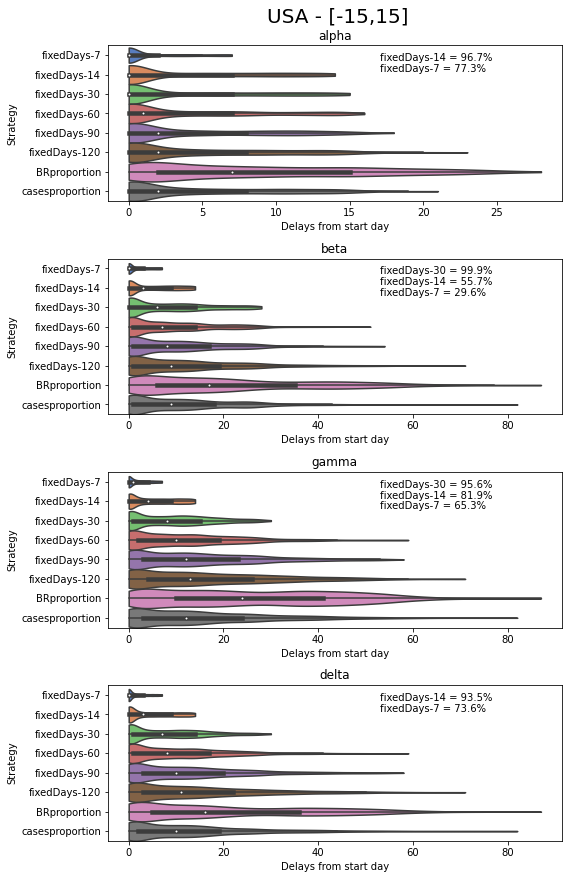

In [29]:
#Generat the Violin plots
country = 'usa' #'usa'
if country == 'usa':
    voc_list = ['alpha','beta','gamma','delta']
else:
    voc_list = ['beta','delta','gamma']

NIT = 1000 #10000

strategy_list = ['fixedDays','BRproportion','casesproportion'] #'homogeneousBR'

MAX_DAY = 31

plot_dict = open_pickle_strategies_violinplot(country,NIT,strategy_list,voc_list,MAX_DAY)

In [19]:
def create_table(country,NIT,strategy_list,voc_list,MAX_DAY):
    
    voc_tables = {}
    
    
    for voc in voc_list:
        
        for strategy in strategy_list:
            name_to_save = '{0}'.format(NIT)
            pickle_loc = "/home/renata/Desktop/gabriela_group/final/subsampling_{2}_plot_dict_{0}_{1}_DAYS_{3}_RANDOM_BACK_FORWARD_CORRECTDELAY".format(country,name_to_save,strategy,MAX_DAY)
            
            with open(pickle_loc, 'rb') as handle:
                results_dict = pickle.load(handle)
                            
            if strategy == 'fixednumber':
                for quantil_value in [0.25,0.50,0.75,1]:
                    strategy = 'fixednumber-{0}'.format(quantil_value)
                    list_delays = results_dict[voc][quantil_value][0] #if isinstance(i, str) == False]
                    mean = np.mean(list_delays)
                    std = np.std(list_delays)
                    
                    if mean < 1:
                        ROUND_MEAN = 2
                    elif mean < 10:
                        ROUND_MEAN = 1
                    else:
                        ROUND_MEAN = None
                        
                    if strategy in voc_tables.keys():
                        voc_tables[strategy].append("{0}({1})".format(round(mean,ROUND_MEAN),round(std,ROUND_MEAN)))
                    else:
                        voc_tables[strategy] = ["{0}({1})".format(round(mean,ROUND_MEAN),round(std,ROUND_MEAN))]
            
            elif strategy == 'fixedDays':
                for fixed_days in [7,14,30,60,90,120]:
                
                    strategy = 'fixednumber-{0}'.format(fixed_days)
                    list_delays = results_dict[voc][fixed_days][0] #if isinstance(i, str) == False]
                    mean = np.mean(list_delays)
                    std = np.std(list_delays)
                    if mean < 1:
                        ROUND_MEAN = 2
                    elif mean < 10:
                        ROUND_MEAN = 1
                    else:
                        ROUND_MEAN = None
                    
                    try:
                        mean = round(mean,ROUND_MEAN)
                        std = round(std,ROUND_MEAN)
                    except:
                        mean = 'None'
                        std = ''
                        
                    if strategy in voc_tables.keys():
                        voc_tables[strategy].append("{0}({1})".format(mean,std))
                    else:
                        voc_tables[strategy] = ["{0}({1})".format(mean,std)]
            else:
                list_delays =  results_dict[voc]
                mean = np.mean(list_delays)
                std = np.std(list_delays)
                
                if mean < 1:
                    ROUND_MEAN = 2
                elif mean < 10:
                    ROUND_MEAN = 1
                else:
                    ROUND_MEAN = None
                
                mean = round(mean,ROUND_MEAN)
                std = round(std,ROUND_MEAN)
                        
                if strategy in voc_tables.keys():
                    voc_tables[strategy].append("{0}({1})".format(mean,std))
                else:
                    voc_tables[strategy] = ["{0}({1})".format(mean,std)]           
    
    df_table = pd.DataFrame.from_dict(voc_tables)
    df_table.index = voc_list
    
    return df_table

In [20]:
#Generat the tables 
country = 'en' #'usa'
if country == 'usa':
    voc_list = ['alpha','beta','gamma','delta']
else:
    voc_list = ['beta','delta','gamma']

NIT = 1000 #10000

strategy_list = ['fixedDays','BRproportion','casesproportion'] #'homogeneousBR'

MAX_DAY = 31

df_table = create_table(country,NIT,strategy_list,voc_list,MAX_DAY)

/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
if MAX_DAY == 1:
    print('{0}-Strategies (starting from day {1})'.format(country,MAX_DAY -1))
else:
    print('{0}-Strategies (starting from day 0 to {1})'.format(country,MAX_DAY -1))
df_table

en-Strategies (starting from day 0 to 30)


,fixednumber-7,fixednumber-14,fixednumber-30,fixednumber-60,fixednumber-90,fixednumber-120,BRproportion,casesproportion,homogeneousBR
beta,1.4(2.1),3.7(4.6),4.8(5.5),5.6(5.9),6.0(6.0),6.5(6.1),14(11),6.1(6.0),13(11)
delta,1.3(2.2),3.4(4.6),3.6(5.0),4.0(5.1),4.4(5.1),4.7(5.4),4.1(5.1),5.0(5.5),8.0(7.1)
gamma,None(),None(),24(4),40(11),50(15),54(18),60(18),71(29),82(28)


## DAILY BUDGET PLOT

In [50]:
def daily_budget_plot(country,NIT,MAX_DAY,strategy_list,voc,FIXED_DAYS_LIST):

    time_series = []
    voc_list_df = []
    daily_budget_df = []
    strategy_list_df = []
    random_start_list = []
    
    for strategy in strategy_list:
        
        if strategy == 'fixedDays':
            
            percentil_list = []
            df_country = start_from_random_back_forward_between_designation(voc,country,MAX_DAY)
            br_budget = fixed_budget_and_dataset_for_variant(voc)

            for fixed_day in [7,14,30,60,90,120]:
                strategy_name = '{0} - {1}'.format(strategy,fixed_day)
                daily_budget = br_budget/fixed_day
                print(br_budget, fixed_day, daily_budget)

                for start_day in FIXED_DAYS_LIST:
                    df_country_iter = df_country.iloc[start_day:]
                    
                    try:
                        END_DAY = df_country['delay'][start_day+fixed_day]
                    except:
                        END_DAY = df_country['delay'][len(df_country['delay'])-1] #last day of time series
                        
                    for index, row in df_country_iter.iterrows():
                        if row['delay'] <= END_DAY:
                            
                            time_series.append(row['delay'])
                            voc_list_df.append(voc)
                            strategy_list_df.append(strategy_name)
                            percentil_list.append(fixed_day)
                            random_start_list.append(start_day-int(MAX_DAY/2))
                            daily_budget_df.append(daily_budget)

            #print(len(time_series),len(daily_budget_df),len(strategy_list_df),len(voc_list_df),len(random_start_list),len(percentil_list))
            plot_dict_fixed = {'Days since pandemic start': time_series, 'Daily budget':daily_budget_df, 'Strategy':strategy_list_df,
                 'VOC':voc_list_df, 'randomstart': random_start_list, 'Fixed days': percentil_list}

            plot_dict_fixed = pd.DataFrame(plot_dict_fixed)

            time_series = []
            voc_list_df = []
            daily_budget_df = []
            strategy_list_df = []
            random_start_list = []


        elif strategy == 'BRproportion':
            br_budget, br_df = fixed_budget_and_dataset_for_variant(voc,RETURN_DT = True)

            for start_day in FIXED_DAYS_LIST:

                br_df_iter = br_df.iloc[start_day:]
                days_list = br_df_iter['delay']

                time_series.extend(days_list)
                voc_list_df.extend([voc]*len(days_list))
                strategy_list_df.extend([strategy]*len(days_list))
                random_start_list.extend([start_day-int(MAX_DAY/2)]*len(days_list))
                daily_budget_df.extend(br_df_iter['N'])

        elif strategy == 'casesproportion':
            df_country, df_country_cases = start_from_random_back_forward_between_designation(voc,country,MAX_DAY,True)        
#             days_list = df_country_cases['delay']

#             time_series.extend(days_list)
#             voc_list_df.extend([voc]*len(days_list))
#             strategy_list_df.extend([strategy]*len(days_list))
#             random_start_list.extend(['Real cases']*len(days_list))
#             daily_budget_df.extend(df_country_cases['Ncases'])

            for start_day in FIXED_DAYS_LIST:

                df_country_cases_iter = df_country_cases.iloc[start_day:]
                days_list = df_country_cases_iter['delay']

                time_series.extend(days_list)
                voc_list_df.extend([voc]*len(days_list))
                strategy_list_df.extend([strategy]*len(days_list))
                random_start_list.extend([start_day-int(MAX_DAY/2)]*len(days_list))

                for index,row in df_country_cases_iter.iterrows():
                    dayproportion = float(df_country_cases_iter['Ncases'][index])/float(sum(df_country_cases['Ncases'])) #propotion of cases in relation to the total amount of cases
                    daily_budget = float(br_budget)*float(dayproportion)
                    daily_budget_df.append(int(daily_budget))


    plot_dict = {'Days since pandemic start': time_series, 'Daily budget':daily_budget_df, 'Strategy':strategy_list_df,
                 'VOC':voc_list_df, 'randomstart': random_start_list}
    plot_dict = pd.DataFrame(plot_dict)

    return plot_dict, plot_dict_fixed #,plot_dict_fixed_number


15204 7 2172.0
15204 14 1086.0
15204 30 506.8
15204 60 253.4
15204 90 168.93333333333334
15204 120 126.7


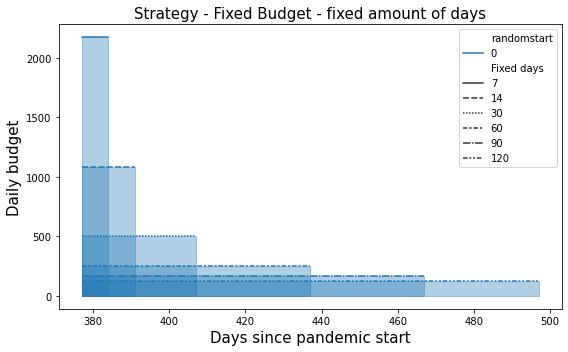

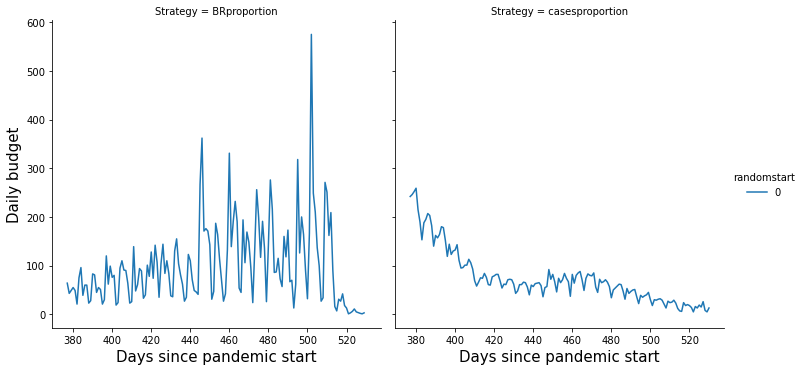

In [51]:
country = 'usa'
NIT = 1000
MAX_DAY = 31
strategy_list = ['fixedDays','fixednumber','BRproportion','casesproportion']
strategy_list = ['fixedDays','BRproportion','casesproportion']

FIXED_DAYS_LIST = [15]

voc = 'gamma'
#plot_dict, plot_dict_fixed,plot_dict_fixed_number = daily_budget_plot(country,NIT,MAX_DAY,strategy_list,voc,FIXED_DAYS_LIST)
plot_dict, plot_dict_fixed  = daily_budget_plot(country,NIT,MAX_DAY,strategy_list,voc,FIXED_DAYS_LIST)

#Plot
fig, (axs1) = plt.subplots(1, figsize=(8,5), sharex=False, sharey=False)
# axs0 = sns.lineplot(data=plot_dict_fixed_number, x="Days", y="Daily budget", hue="randomstart",style = 'Percentils',ax = axs0,palette="tab10")#style="randomstart"
# for line in axs0.lines:
#     x, y = line.get_xydata().T
#     axs0.fill_between(x, 0, y,color=line.get_color(), alpha=0.35)
# axs0.legend(loc='upper right')
# axs0.set_title('Strategy - Fixed Budget - percentil of time series')

axs1 = sns.lineplot(data=plot_dict_fixed, x='Days since pandemic start', y="Daily budget", hue="randomstart",style = 'Fixed days',ax = axs1,palette="tab10")#style="randomstart"
for line in axs1.lines:
    x, y = line.get_xydata().T
    axs1.fill_between(x, 0, y,color=line.get_color(), alpha=0.35)
axs1.legend(loc='upper right',fontsize=10)
axs1.set_title('Strategy - Fixed Budget - fixed amount of days',fontsize = 15)
axs1.set_xlabel('Days since pandemic start',fontsize=15)
axs1.set_ylabel("Daily budget",fontsize=15)

plt.savefig("/home/renata/Desktop/gabriela_group/final/strategies_plot_fixed_{0}_{1}.png".format(country,voc),dpi=200,transparent = False,bbox_inches = 'tight',facecolor = 'white')

ps = sns.relplot(data=plot_dict, x='Days since pandemic start', y="Daily budget", hue="randomstart", col="Strategy",kind='line',palette="tab10")#style="randomstart"
ps.set_axis_labels('Days since pandemic start', "Daily budget",size=15)
#ps.set_titles('Days since pandemic start','Cases proportion',size=15)


# axes = ps.axes.flatten()
# for ax in axes:
#     ax.axhline(200, ls='--', linewidth=3, color='red')
fig.tight_layout()

plt.savefig("/home/renata/Desktop/gabriela_group/final/strategies_plot_BR_cases_{0}_{1}.png".format(country,voc),dpi=200,transparent = False,bbox_inches = 'tight',facecolor = 'white')